# Sentiment analysis of product reviews with Keras Tensorflow

**Project by**:
Yuliana Yakimchuk

## Methodology

### Dependencies

In [1]:
# Utilities
import os
import re
import json

# Data munging
import pandas as pd
import numpy as np

# Text processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.decomposition import TruncatedSVD

# Feature Engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.base import TransformerMixin

# Modelling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
import joblib
#!pip install h5py scikit-optimize
#from skopt import BayesSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import learning_curve

## Data retrieval and exploration

In [2]:
import pandas as pd
reviews_df = pd.read_json('Electronics_5.json', lines=True, nrows = 100000)
#the original file contains over 6 million reviews. For the saeke of computational manageability, we'll only work with 100K reviews

In [3]:
reviews_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN


In [4]:
reviews_df.info()
#we have lots of missing values in many categories, but we will only use reviewText and overall columns 
#for our sentiment analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         100000 non-null  int64 
 1   vote            17157 non-null   object
 2   verified        100000 non-null  bool  
 3   reviewTime      100000 non-null  object
 4   reviewerID      100000 non-null  object
 5   asin            100000 non-null  object
 6   style           61750 non-null   object
 7   reviewerName    99984 non-null   object
 8   reviewText      99986 non-null   object
 9   summary         99992 non-null   object
 10  unixReviewTime  100000 non-null  int64 
 11  image           1000 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 8.5+ MB


array([[<AxesSubplot:title={'center':'overall'}>]], dtype=object)

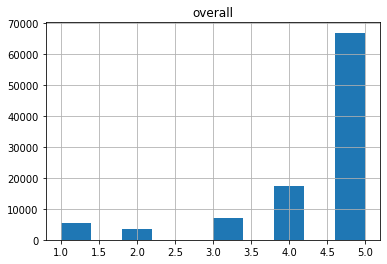

In [5]:
reviews_df.hist(column = 'overall')

## based on the above histogram, we can see that our dataset is heavily imbalanced, with the majority of reviews being positive, and only a small portion of negative reviews. We will have to address it when we train our model

### Preprocessing and Feature Engineering

#### Data Preprocessing

In [6]:
#first we should get rid of the features we will not be using for our analysis - i.e. everything except 'overall'
#and reviewText:
review_df = reviews_df[['overall','reviewText']]
review_df.head()

,overall,reviewText
0,5,This is the best novel I have read in 2 or 3 y...
1,3,"Pages and pages of introspection, in the style..."
2,5,This is the kind of novel to read when you hav...
3,5,What gorgeous language! What an incredible wri...
4,3,I was taken in by reviews that compared this b...


In [7]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     100000 non-null  int64 
 1   reviewText  99986 non-null   object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [8]:
#we have some null values in review text, given the size of the dataset, we'll just remove these rows
review_df.dropna(inplace = True)
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99986 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   overall     99986 non-null  int64 
 1   reviewText  99986 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


C:\Users\VR\AppData\Local\Temp\ipykernel_6660\4124327781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df.dropna(inplace = True)


In [9]:
#we will save this prepped dataset to a .csv file in case we need to laod it again
review_df.to_csv('electronics_prepped.csv')
#review_df = pd.read_csv('electronics_prepped.csv')

In [10]:
#for our usecase, we'll consider reviews with 1-2 stars as negative, 3 stars as neutral and 4-5 stars as positive
review_df['rating']= review_df['overall'].map(lambda x: 0 if x in [1,2] else 1 if x==3 else 2 )

C:\Users\VR\AppData\Local\Temp\ipykernel_6660\4120745393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['rating']= review_df['overall'].map(lambda x: 0 if x in [1,2] else 1 if x==3 else 2 )


In [11]:
review_df

,overall,reviewText,rating
0,5,This is the best novel I have read in 2 or 3 y...,2
1,3,"Pages and pages of introspection, in the style...",1
2,5,This is the kind of novel to read when you hav...,2
3,5,What gorgeous language! What an incredible wri...,2
4,3,I was taken in by reviews that compared this b...,1
...,...,...,...
99995,5,excellent,2
99996,5,This product is excellent I feel very safe usi...,2
99997,5,It does an excellent job of cleaning.,2
99998,5,Very efficient,2


In [12]:
review_df[review_df['overall']==2]

,overall,reviewText,rating
16,2,"This remote, for whatever reason, was chosen b...",0
18,2,I have an older URC-WR7 remote and thought thi...,0
54,2,My brother is a trucker and pre-ordered this. ...,0
57,2,No up dates after 3 years!,0
62,2,"Not going to write a long review, even thought...",0
...,...,...,...
99728,2,"Does not fit, i have a sony reel to reel audio...",0
99740,2,Do NOT get this for old electronics that requi...,0
99754,2,The Male end fits loosely into some inputs whi...,0
99870,2,It did not meet standards.,0


In [13]:
# alll assigned correctly, we can drop the redundant "overall" feature now:
review_df = review_df.drop(columns = ['overall'])
review_df.head()

,reviewText,rating
0,This is the best novel I have read in 2 or 3 y...,2
1,"Pages and pages of introspection, in the style...",1
2,This is the kind of novel to read when you hav...,2
3,What gorgeous language! What an incredible wri...,2
4,I was taken in by reviews that compared this b...,1


!pip install pyspellchecker

In [84]:
#creating a multi-step NLP preprocessor for the base model
class Preprocessor():
     
    def __init__(self):
        return None
    
    def remove_special(self, sequence): #remove special characters (including numbers &tags, but excluding spaces)
        import re
        sequence = re.sub(r'[^A-Za-z0-9\s]', "", sequence)
        return sequence
        
        
    def spellcheck(self, sequence):  #module that corrects common spelling mistakes.
        from spellchecker import SpellChecker
        spell = SpellChecker()
        sequence = spell.correction(sequence)  
        return sequence
    
    def tokenize_lemmatize(self,sequence): #tokenize and lemmatize sequences
        from nltk import word_tokenize          
        from nltk.stem import WordNetLemmatizer
        from nltk.corpus import stopwords
        
        tokens = word_tokenize(sequence.lower())
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words("english"))
        
        sequence = str()
        for word in tokens:
            if word not in stop_words:
                word = lemmatizer.lemmatize(word)
                sequence += f" {word}"
        return sequence
    
    def __call__(self,sequence, y = None):   #implementing call method is required for passing to tf-idf
        sequence = self.remove_special(sequence)
        sequence = self.spellcheck(sequence)
        sequence = self.tokenize_lemmatize(sequence)
        return sequence

In [85]:
inst = Preprocessor()

In [86]:
copy=review_df[:10]
copy

,reviewText,rating
0,This is the best novel I have read in 2 or 3 y...,2
1,"Pages and pages of introspection, in the style...",1
2,This is the kind of novel to read when you hav...,2
3,What gorgeous language! What an incredible wri...,2
4,I was taken in by reviews that compared this b...,1
5,I read this probably 50 years ago in my youth ...,2
6,I read every Perry mason book voraciously. Fin...,2
7,I love this series of Bertha and Lamb.. Great...,2
8,Great read!,2
9,"Crows Can't Count, A.A. Fair\n\nMr. Harry Shar...",2


In [87]:
copy['reviewText']=copy['reviewText'].apply(inst)

C:\Users\VR\AppData\Local\Temp\ipykernel_6660\1003064821.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['reviewText']=copy['reviewText'].apply(inst)


In [88]:
copy.head()

,reviewText,rating
0,best novel read 2 3 year everything fiction b...,2
1,page page introspection style writer like hen...,1
2,kind novel read time lose book day possibly w...,2
3,gorgeous language incredible writer last life...,2
4,taken review compared book leopard promised b...,1
